In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


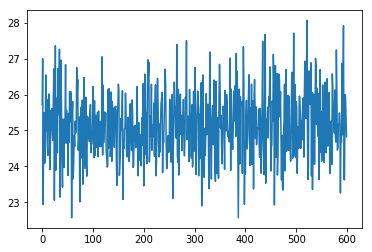

In [4]:
plt.plot(nino34[::12]);

In [5]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [6]:
oni = ONI(nino34)

In [7]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [8]:
clm = climatology(nino34)

In [9]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [10]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [11]:
T = 1      # prediction timeline
H = 48   # history used for prediction
include_month = 1           # 1 if we use the month as a feature, 0 otherwise
threshold = 0.5         
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [12]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
         data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

labels = np.ndarray((size), dtype = np.float64)
        
for i in range(size):
    labels[i] = anm[i + H + T]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

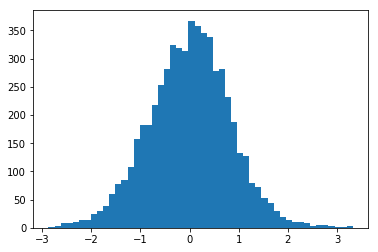

In [13]:
plt.hist(train_labels, bins=50);

# Simple Model

In [28]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 60

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

model.fit(train, train_labels, epochs = epochs, verbose = 1)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

Epoch 1/60
5720/5720 [==============================] - 3s 498us/step - loss: 0.4039 - mean_squared_error: 0.2720 - mean_absolute_error: 0.4039
Epoch 2/60
5720/5720 [==============================] - 2s 410us/step - loss: 0.3443 - mean_squared_error: 0.1950 - mean_absolute_error: 0.3443
Epoch 3/60
5720/5720 [==============================] - 2s 393us/step - loss: 0.3307 - mean_squared_error: 0.1787 - mean_absolute_error: 0.3307
Epoch 4/60
5720/5720 [==============================] - 2s 397us/step - loss: 0.3212 - mean_squared_error: 0.1719 - mean_absolute_error: 0.3212
Epoch 5/60
5720/5720 [==============================] - 2s 399us/step - loss: 0.3136 - mean_squared_error: 0.1650 - mean_absolute_error: 0.3136
Epoch 6/60
5720/5720 [==============================] - 2s 366us/step - loss: 0.3065 - mean_squared_error: 0.1572 - mean_absolute_error: 0.3065
Epoch 7/60
5720/5720 [==============================] - 2s 351us/step - loss: 0.3033 - mean_squared_error: 0.1544 - mean_absolute_error:

5720/5720 [==============================] - 2s 372us/step - loss: 0.1103 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1103
Epoch 58/60
5720/5720 [==============================] - 2s 340us/step - loss: 0.1125 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1125
Epoch 59/60
5720/5720 [==============================] - 3s 443us/step - loss: 0.1066 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1066
Epoch 60/60
5720/5720 [==============================] - 3s 456us/step - loss: 0.1064 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1064
0.1321967035010978 0.2816662374909941


In [29]:
pred = model.predict(train)

In [30]:
print(mean_squared_error(train_labels, pred))
print(mean_absolute_error(train_labels, pred))

0.01794149908594122
0.09606306789382325


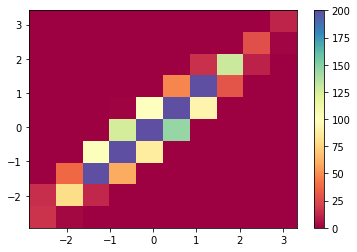

In [31]:
plt.hist2d(train_labels, pred[:,0], cmap = plt.cm.Spectral, vmax = 200);
plt.colorbar();

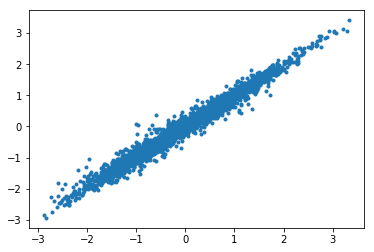

In [32]:
plt.plot(train_labels, pred[:,0], ".");

In [33]:
pred_val = model.predict(val)

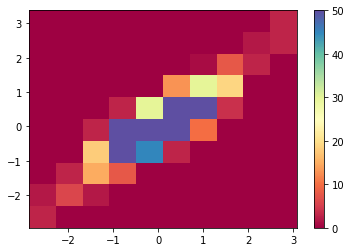

In [34]:
plt.hist2d(val_labels, pred_val[:,0], cmap = plt.cm.Spectral, vmax = 50);
plt.colorbar();

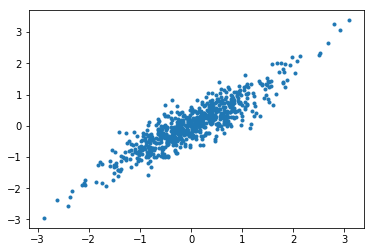

In [35]:
plt.plot(val_labels, pred_val[:,0], ".");

In [36]:
def correlation(x, y):
    x0 = x - np.mean(x)
    y0 = y - np.mean(y)
    return np.mean(x0 * y0) / np.sqrt((np.mean(x0**2) * (np.mean(y0**2))))

In [37]:
print(correlation(train_labels, pred[:,0]))
print(correlation(val_labels, pred_val[:,0]))

0.9871177680021447
0.8985709819639672


# Simple Regressors

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
model.fit(train,train_labels)

# Get the mean absolute error on the validation data
predicted = model.predict(val)
MAE = mean_absolute_error(val_labels , predicted)
MSE = mean_squared_error(val_labels , predicted)
print(MAE, MSE)

0.3379193737340224 0.18315726391241222


In [39]:
print(correlation(train_labels, model.predict(train)))
print(correlation(val_labels, model.predict(val)))

0.9769522153412149
0.8550638903247622


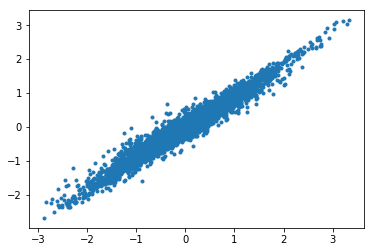

In [19]:
plt.plot(anm[train_ind + H + T], model.predict(train), ".");

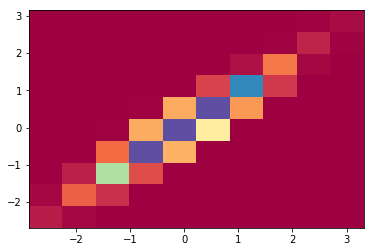

In [20]:
plt.hist2d(anm[train_ind + H + T], model.predict(train), cmap = plt.cm.Spectral, vmax = 500);

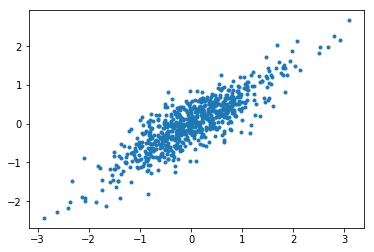

In [21]:
plt.plot(anm[val_ind + H + T], model.predict(val), ".");

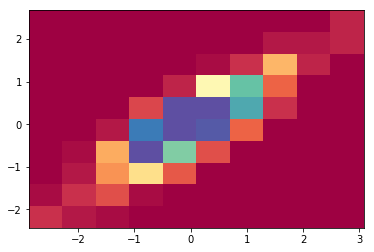

In [22]:
plt.hist2d(anm[val_ind + H + T], model.predict(val), cmap = plt.cm.Spectral, vmax = 50);

In [40]:
from sklearn import svm

model = svm.SVR()
model.fit(train,train_labels)

predicted = model.predict(val)
MAE = mean_absolute_error(val_labels , predicted)
MSE = mean_squared_error(val_labels , predicted)

print(MAE, MSE)

0.29879015922872193 0.14113689234541085


In [41]:
print(correlation(train_labels, model.predict(train)))
print(correlation(val_labels, model.predict(val)))

0.9190422945368004
0.8909768867833908


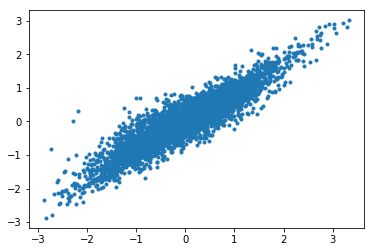

In [24]:
plt.plot(anm[train_ind + H + T], model.predict(train), ".");

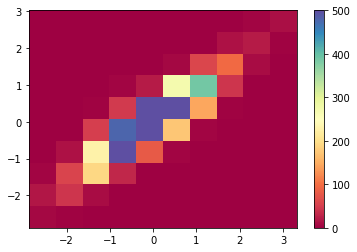

In [25]:
plt.hist2d(anm[train_ind + H + T], model.predict(train), cmap = plt.cm.Spectral, vmax = 500);
plt.colorbar();

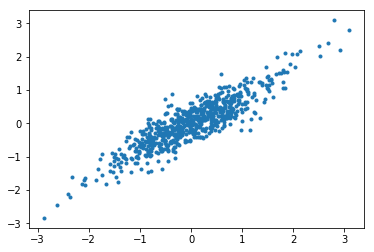

In [26]:
plt.plot(anm[val_ind + H + T], model.predict(val), ".");

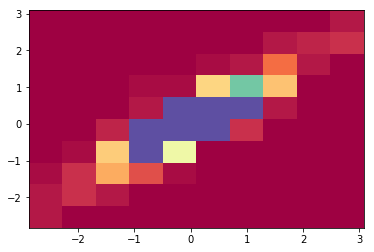

In [27]:
plt.hist2d(anm[val_ind + H + T], model.predict(val), cmap = plt.cm.Spectral, vmax = 50);